## ☁️ Connect G-Drive

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework 2 AN2DL condivisa/Final Notebooks/Baseline U-Net (Cleaned dataset)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/1SjZ_-XjkG_FsuR9orhSxIGp-dNxNdzS1/Homework 2 AN2DL condivisa/Final Notebooks/Baseline U-Net (Cleaned dataset)


## ⚒️ Import libraries

In [5]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.17.1


## 📊 Load data (no 👽)

In [6]:
data = np.load("../../Datasets/Dataset_without_aliens.npz")
training_set = data["training_set"]

X_train = training_set[0, :]
y_train = training_set[1, :]

X_test = data["test_set"]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(2505, 64, 128)
(2505, 64, 128)
(10022, 64, 128)


## 📈 Parameters

In [7]:
# Set batch size for training
BATCH_SIZE = 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 10

# Set maximum number of training epochs
EPOCHS = 1000

# Number of classes
NUM_CLASSES = 5

## Building dataset

In [8]:
# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=0.1, random_state=seed
)

print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

del train_val_img, train_val_lbl

Splitting data...
Data splitted!

Number of images:
Train: 2028
Validation: 226
Test: 251


In [9]:
def make_dataset(image_paths, label_paths, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [10]:
# Create the datasets
print("Creating datasets...")

train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128)
Images shape: (64, 64, 128)
Labels shape: (64, 64, 128)
Labels dtype: <dtype: 'float64'>


## Network

In [11]:
def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

In [12]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

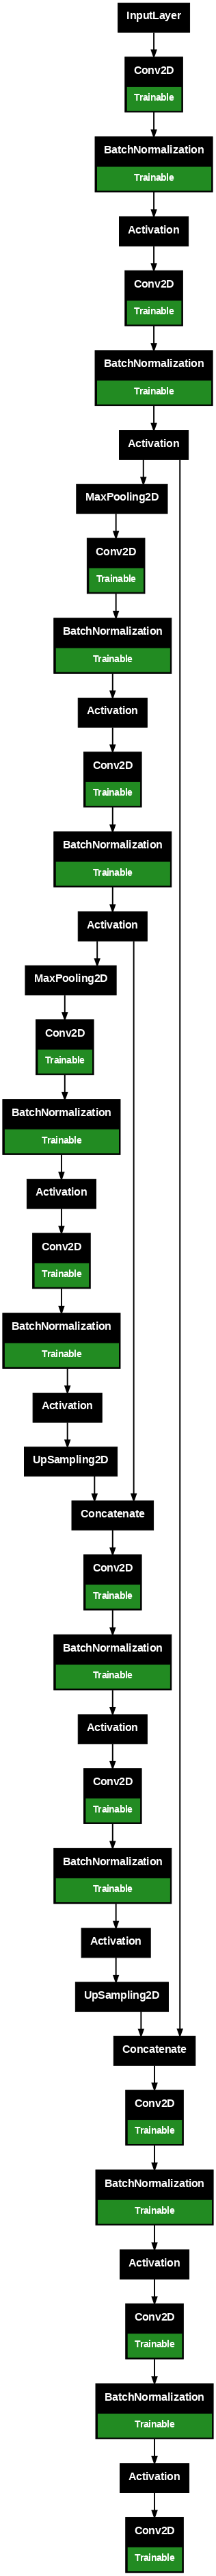

In [13]:
model = get_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [14]:
# Mean IntersectionOverUnion as metric
mean_iou = tfk.metrics.MeanIoU(num_classes=NUM_CLASSES, ignore_class=0, sparse_y_pred=False)

# Compile the model
print("Compiling model...")
model.compile(optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", mean_iou])
print("Model compiled!")

Compiling model...
Model compiled!


In [15]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_io_u',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)


## 💪 Train the network

In [16]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping],#, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_io_u'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)

# Delete the model to free up resources
del model

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 751ms/step - accuracy: 0.3506 - loss: 1.5337 - mean_io_u: 0.1621 - val_accuracy: 0.0384 - val_loss: 22.6630 - val_mean_io_u: 0.0124
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.5609 - loss: 1.1470 - mean_io_u: 0.2865 - val_accuracy: 0.3853 - val_loss: 1.9795 - val_mean_io_u: 0.1857
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6115 - loss: 1.0157 - mean_io_u: 0.3264 - val_accuracy: 0.5279 - val_loss: 1.1903 - val_mean_io_u: 0.2819
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.6412 - loss: 0.9303 - mean_io_u: 0.3557 - val_accuracy: 0.6035 - val_loss: 1.1696 - val_mean_io_u: 0.3013
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.6479 - loss: 0.9151 - mean_io_u: 0.3605 - val_accuracy: 0.5110 - val_loss: 1.3693 - val_mean_io_u: 0.2432
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.6711 - loss: 0.8525 - mean_io_u: 0.3772 - val_accuracy: 0.55

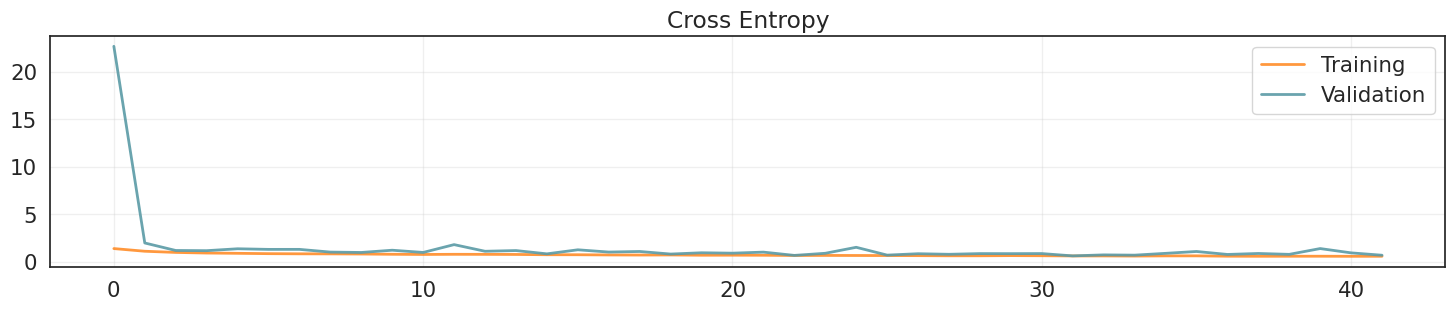

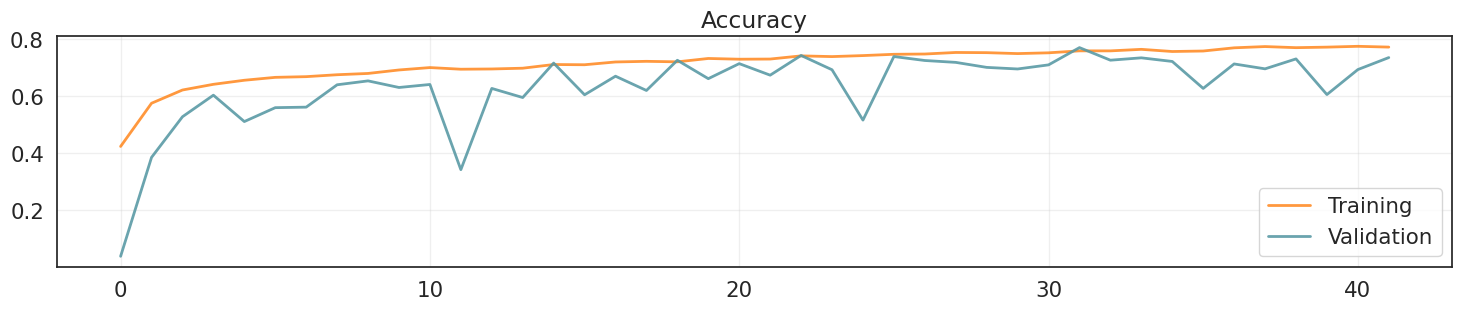

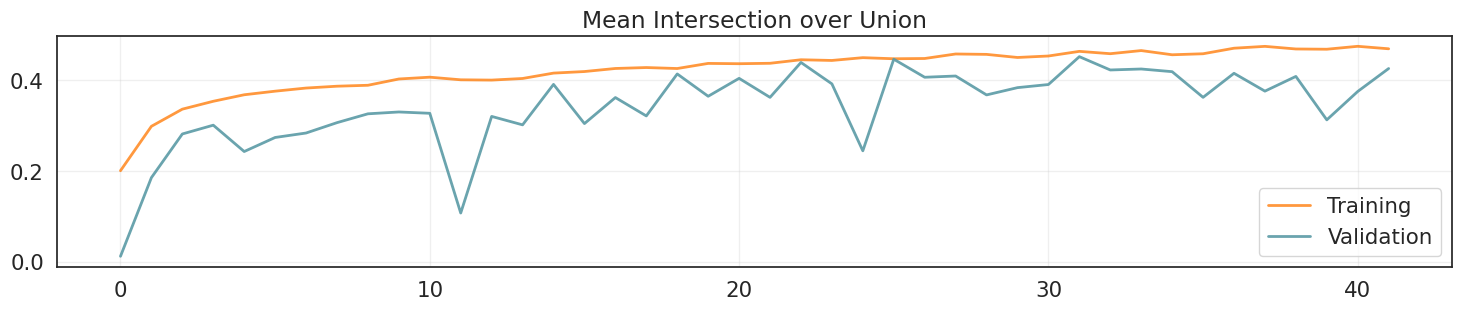

In [17]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_io_u'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_io_u'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 🔎 Inference using the model

Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer            │ (None, 64, 128, 1)   │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv1      │ (None, 64, 128, 32)  │          320 │ input_layer[0][0]   │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn1        │ (None, 64, 128, 32)  │          128 │ down_block1_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_conv2      │ (None, 64, 128, 32)  │        9,248 │ down_block1_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_bn2        │ (None, 64, 128, 32)  │          128 │ down_block1_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block1_activatio… │ (None, 64, 128, 32)  │            0 │ down_block1_bn2[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ max_pooling2d          │ (None, 32, 64, 32)   │            0 │ down_block1_activa… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv1      │ (None, 32, 64, 64)   │       18,496 │ max_pooling2d[0][0] │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn1        │ (None, 32, 64, 64)   │          256 │ down_block2_conv1[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_activatio… │ (None, 32, 64, 64)   │            0 │ down_block2_bn1[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_conv2      │ (None, 32, 64, 64)   │       36,928 │ down_block2_activa… │    Y    │
│ (Conv2D)               │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ down_block2_bn2        │ (None, 32, 64, 64)   │          256 │ down_block2_conv2[… │    Y    │
│ (BatchNormalization)   │                      │              │                     │         │
├──────────────────────

 Total params: 473,669 (1.81 MB)

 Trainable params: 472,389 (1.80 MB)

 Non-trainable params: 1,280 (5.00 KB)

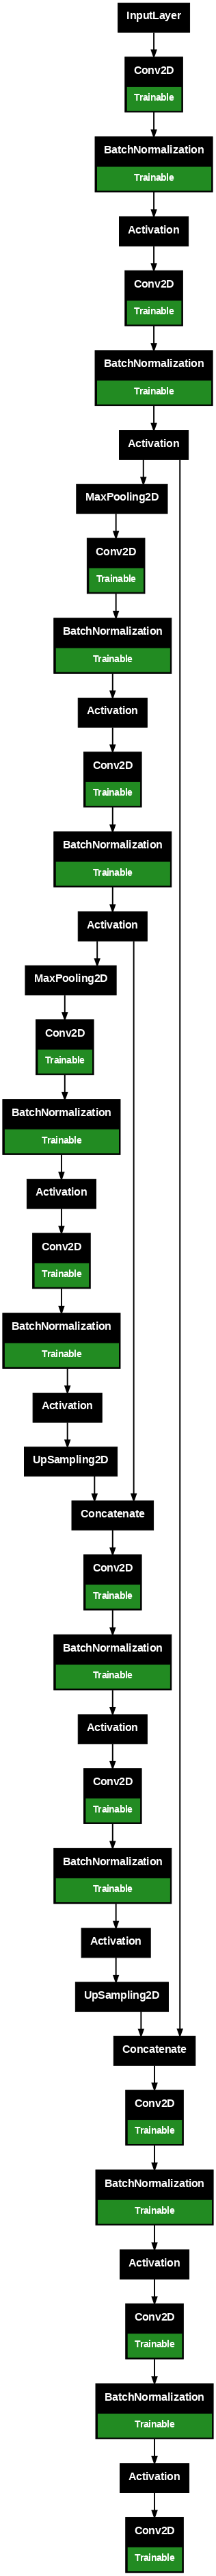

In [19]:
# Load UNet model without compiling
model_filename = 'UNet_45.23.keras'
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy", mean_iou])

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [20]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=1, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7233 - loss: 0.7309 - mean_io_u: 0.4276
Test Accuracy: 0.7422
Test Mean Intersection over Union: 0.4305


In [22]:
preds_first = model.predict(test_img)
preds_first = np.argmax(preds_first, axis=-1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 288ms/step


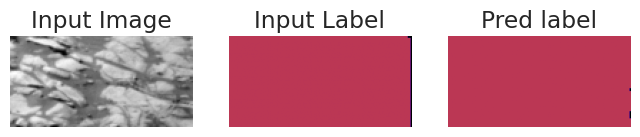

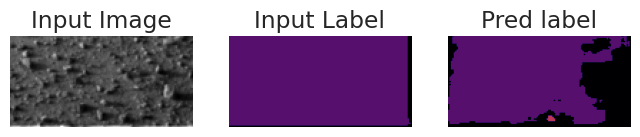

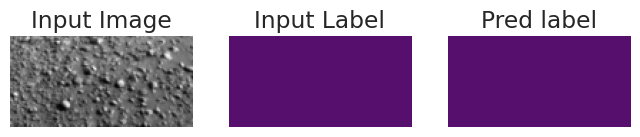

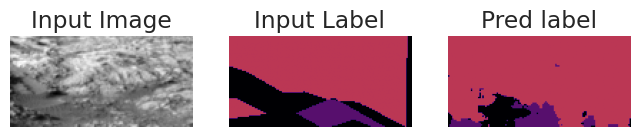

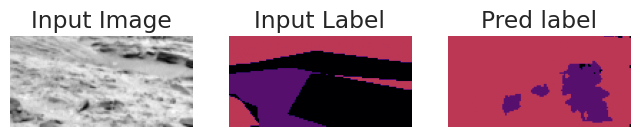

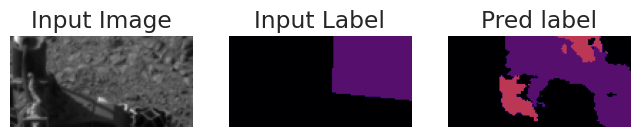

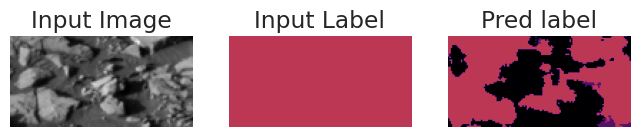

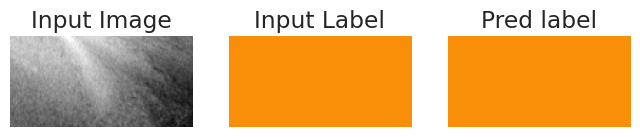

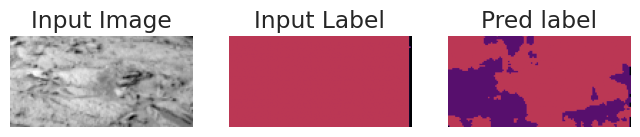

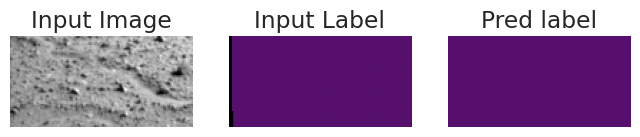

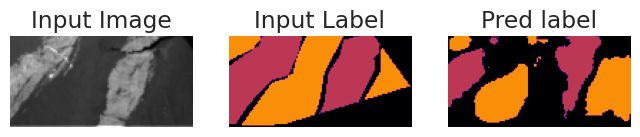

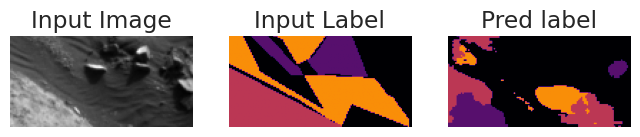

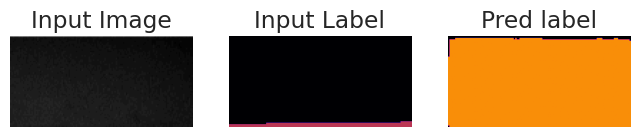

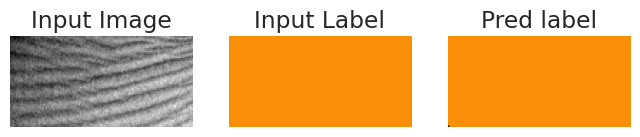

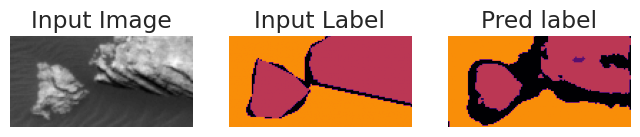

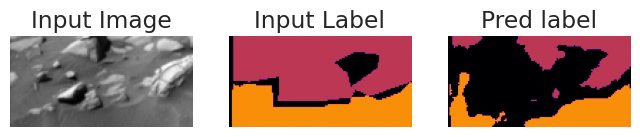

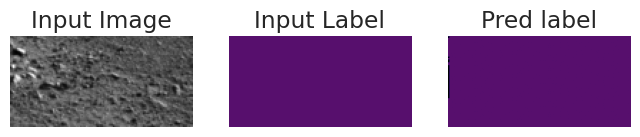

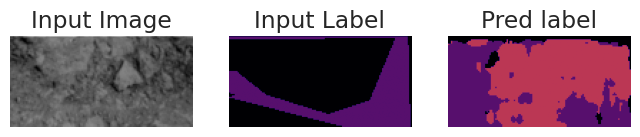

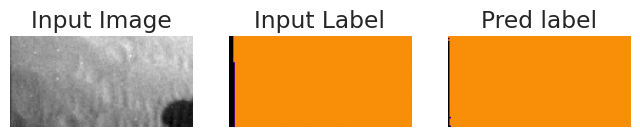

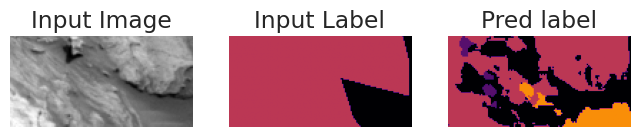

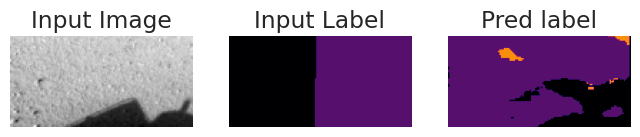

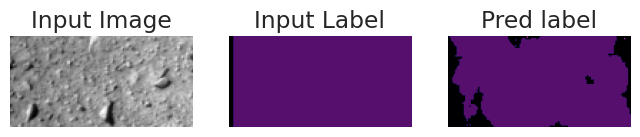

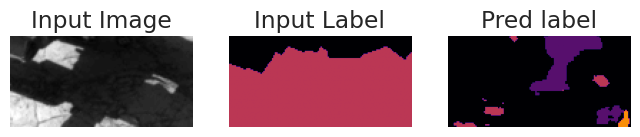

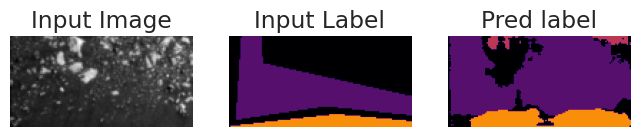

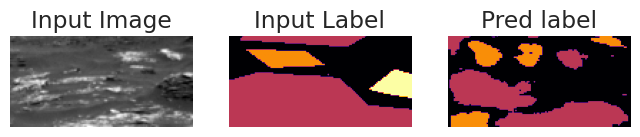

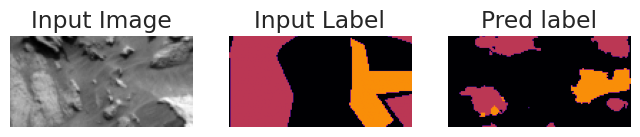

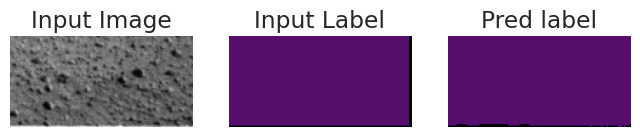

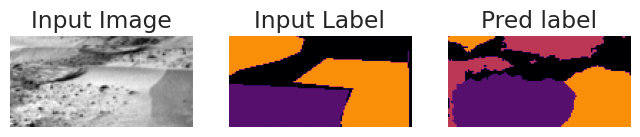

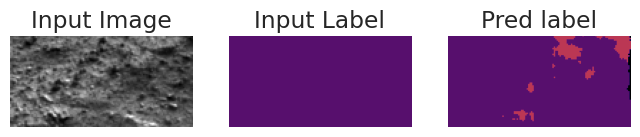

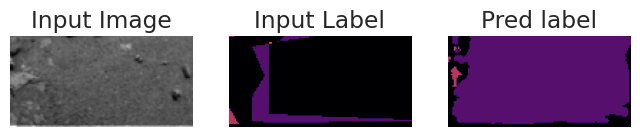

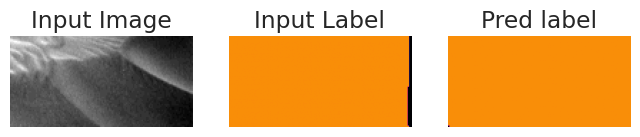

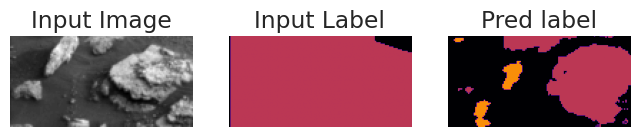

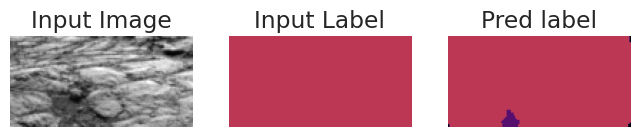

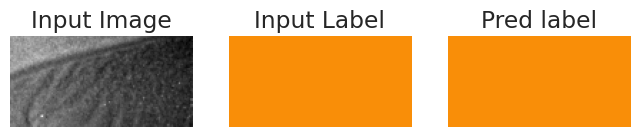

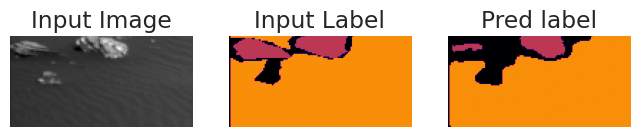

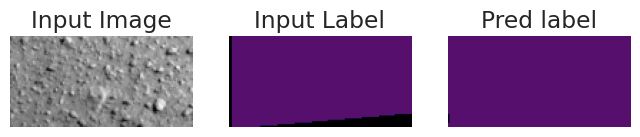

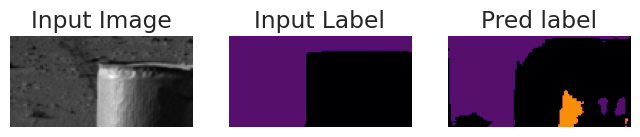

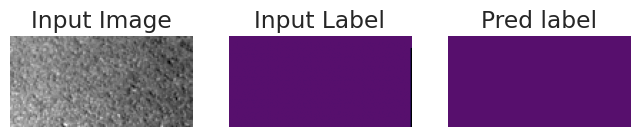

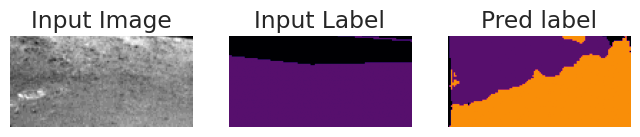

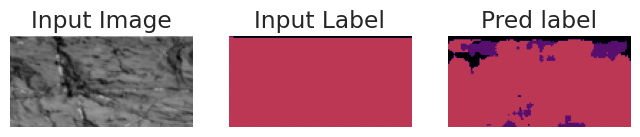

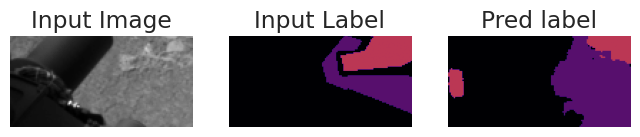

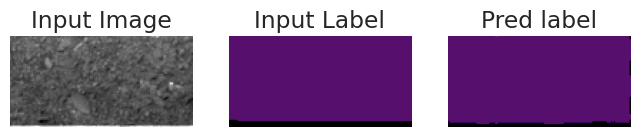

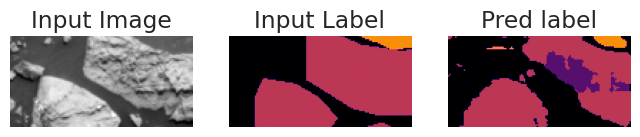

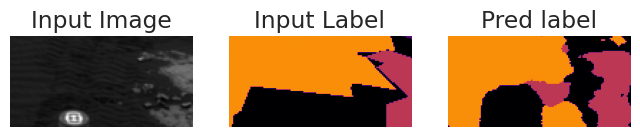

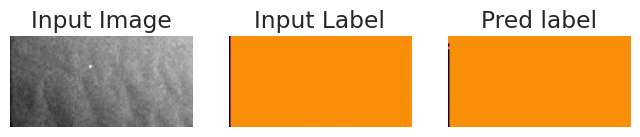

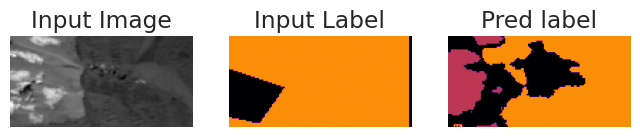

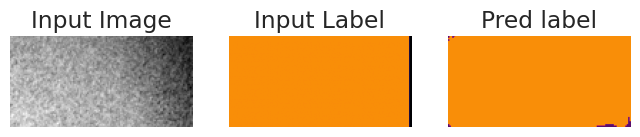

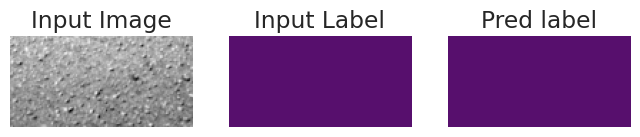

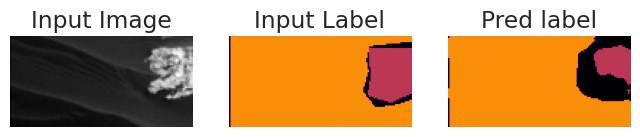

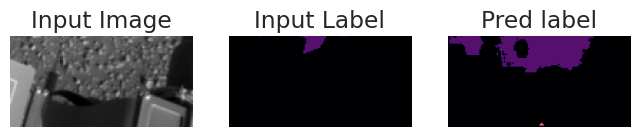

In [23]:
for index in range(50):
  plt.figure(figsize=(8,4))
  plt.subplot(1,3,1)
  plt.imshow(test_img[index], cmap='gray')
  plt.axis('off')
  plt.title("Input Image")
  plt.subplot(1,3,2)
  plt.imshow(test_lbl[index], cmap='inferno',vmin=0,vmax=4)
  plt.axis('off')
  plt.title("Input Label")
  plt.subplot(1,3,3)
  plt.imshow(preds_first[index], cmap='inferno',vmin=0,vmax=4)
  plt.axis('off')
  plt.title("Pred label")
  plt.show()

<Figure size 800x600 with 0 Axes>

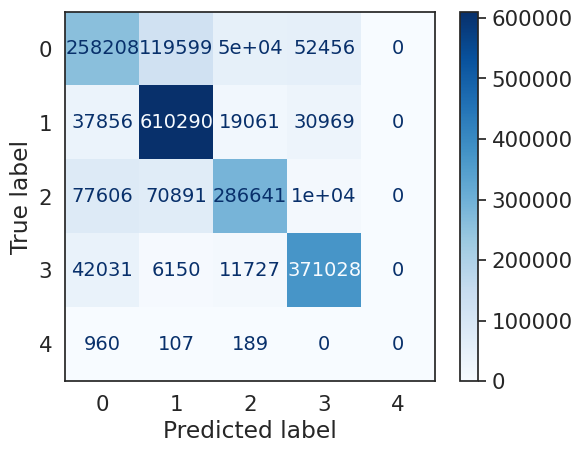

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Flatten the label arrays for comparison
true_labels = test_lbl.flatten()
predicted_labels = preds_first.flatten()

# Compute the confusion matrix
num_classes = 5  # Adjust this based on the number of classes
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=np.arange(num_classes))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.arange(num_classes))
disp.plot(cmap='Blues')  # Use scientific notation for


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [25]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [26]:
print(model_filename)

UNet_45.23.keras


In [27]:
# Load model
model = tfk.models.load_model(model_filename)
print(f"Model loaded from {model_filename}")

Model loaded from UNet_45.23.keras


In [28]:
# Prediction
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
Predictions shape: (10022, 64, 128)


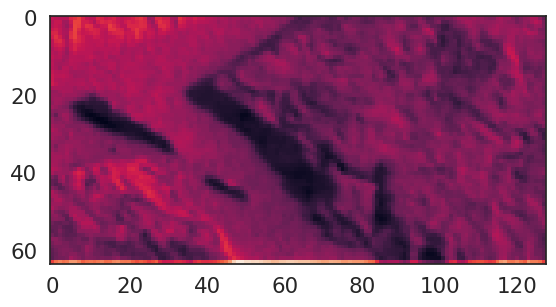

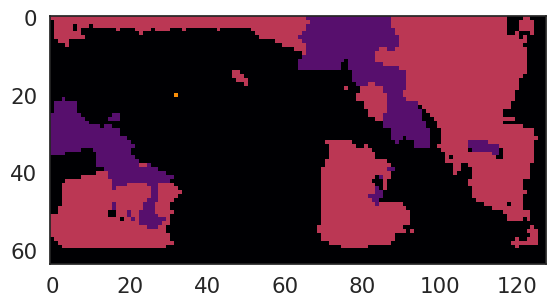

In [29]:
plt.figure()
plt.imshow(X_test[0])
plt.figure()
plt.imshow(preds[0], cmap='inferno',vmin=0,vmax=4)

In [30]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [31]:
# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

from google.colab import files
files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>